Using 100 science fiction novels from project gutenberg. 

Source: https://www.gutenberg.org/wiki/Science_Fiction_(Bookshelf)

In [112]:
import nltk
import pandas as pd
import numpy as np
import books_files as books 
from urllib import request

In [113]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

def text_cleaner(text_data):
    text = re.sub("[^a-zA-Z]",' ',text_data)
    text = text.lower()
    text = text.split()
    lmz = WordNetLemmatizer()
    text = [lmz.lemmatize(word) for word in text if not word in set(stopwords.words('english'))]
    text = ' '.join(text)
    return text

In [114]:
from io import StringIO

book_text = []
authors = []

for k,v in books.url_dict.items():
    for url in v:
        response = request.urlopen(url)
        raw = response.read().decode('utf8')
        s = StringIO(raw)
        text_lines = []
        for i,line in enumerate(s):
            text_lines.append(line)
            if "START OF THIS PROJECT" in line:
                start_index = (i+1)
            if "END OF THIS PROJECT" in line:
                end_index = i
        book_text.append(' '.join(text_lines[start_index:end_index]))
        authors.append(k)

In [115]:
print(len(book_text))

100


In [116]:
text_df = pd.DataFrame()
text_df["Text"] = book_text
text_df["Author"] = authors
text_df.head(3)

,Text,Author
0,"\r\n \r\n \r\n \r\n Produced by Greg Weeks, Ma...",Anderson
1,\r\n \r\n \r\n \r\n Produced by Sankar Viswana...,Anderson
2,\r\n \r\n \r\n \r\n Produced by Sankar Viswana...,Anderson


In [117]:
# bag of words
corpus = []
for text in text_df["Text"]:
    clean_text = text_cleaner(text)
    corpus.append(clean_text)

In [118]:
X = text_df.iloc[:,0].values
y = text_df.iloc[:,1].values

In [119]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

In [120]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_v = TfidfVectorizer(max_df=0.5,
                             min_df =2,
                             stop_words="english",
                             lowercase=True,
                             use_idf=True,
                             norm=u'l2',
                             smooth_idf=True
                            )

In [156]:
X_tfidf = tfidf_v.fit_transform(corpus)
y_tfidf = text_df.iloc[:,1].values

In [157]:
X_tfidf.shape

(100, 18030)

In [158]:
words = tfidf_v.get_feature_names()

In [123]:
X_train_tfidf,X_test_tfidf,y_train_tfidf,y_test_tfidf = train_test_split(X_tfidf,y_tfidf,test_size=0.25,random_state=42)

In [161]:
from sklearn.metrics.pairwise import cosine_similarity

dist = 1 - cosine_similarity(X_tfidf)

## KMeans Cluster

In [130]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,random_state=42)
    kmeans.fit(X_tfidf)
    wcss.append(kmeans.inertia_)

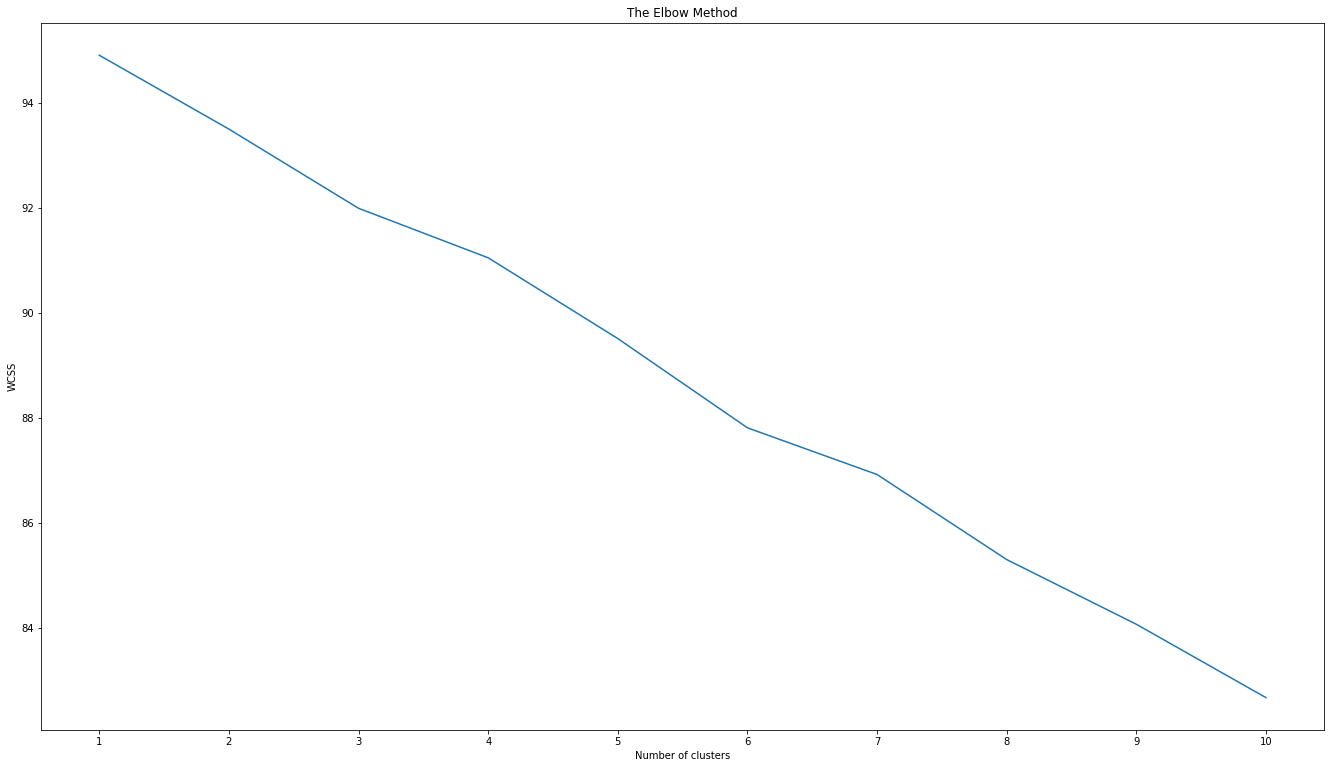

In [131]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (23,13)
plt.plot(range(1,11),wcss)
plt.title("The Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.xticks(range(1,11))
plt.show()

In [167]:
# 6 clusters seems optimal
num_clusters = 6
km = KMeans(n_clusters=num_clusters,random_state=42)

In [168]:
km.fit(X_tfidf)
clusters = km.labels_.tolist()

In [169]:
books = {"author":y_tfidf ,"book_text":corpus,"cluster":clusters}
frame = pd.DataFrame(books,index=[clusters],columns=["author","book_text","cluster"])

In [170]:
frame["cluster"].value_counts()

5    32
3    24
1    23
4    13
0     6
2     2
Name: cluster, dtype: int64

In [182]:
from __future__ import print_function

print("Authors per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d:"%i)
    print("Top 10 words:")
    for ind in order_centroids[i,:10]:
        print("%s"%words[ind])
    print()
    print("Cluster %d authors:" % i, end='')
    for author in frame.loc[i]['author'].values.tolist():
        print(' %s,' % author, end='')
    print() #add whitespace
    print() #add whitespace

Authors per cluster:

Cluster 0:
Top 10 words:
joe
kenzie
guy
instructor
chessman
chief
watson
brett
buckner
baron

Cluster 0 authors: Clifton, Garrett, Reynolds, Reynolds, Reynolds, Williams,

Cluster 1:
Top 10 words:
johnny
mead
kennedy
captain
geoffrey
dane
commodore
ron
aunt
wilkins

Cluster 1 authors: Anderson, Anderson, Anderson, Anderson, Budrys, Budrys, Budrys, Budrys, Clifton, Clifton, Cogan, Del Rey, Del Rey, Fyfe, Fyfe, Fyfe, Fyfe, Reynolds, Reynolds, Reynolds, Reynolds, Williams, Williams,

Cluster 2:
Top 10 words:
nipe
stanton
mannheim
bart
yoritomo
martin
colonel
farnsworth
rat
wang

Cluster 2 authors: Garrett, Garrett,

Cluster 3:
Top 10 words:
colonel
guesser
zen
porter
senator
gibson
bending
charlie
parker
stoker

Cluster 3 authors: Anderson, Anderson, Anderson, Ashwell, Beck, Budrys, Clifton, Clifton, Del Rey, Fyfe, Fyfe, Fyfe, Garrett, Garrett, Garrett, Garrett, Garrett, Leiber, Leiber, Leiber, Leiber, Reynolds, Williams, Williams,

Cluster 4:
Top 10 words:
gordon
th

In [184]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

X_norm = normalize(dist)
X_pca = PCA(n_components=2).fit_transform(X_norm)

In [185]:
xs,ys = X_pca[:,0],X_pca[:,1]

In [193]:
#set up colors per clusters using a dict
cluster_colors = {0: '#b29203', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e',5: '#92f442'}

cluster_names = {0: 'joe, kenzie, guy, instructor, chessman, chief, watson, brett, buckner, baron', 
                 1: 'johnny, mead, kennedy, captain, geoffrey, dane, commodore, ron, aunt, wilkins', 
                 2: 'nipe, stanton, mannheim, bart, yoritomo, martin, colonel, farnsworth, rat, wang', 
                 3: 'colonel, guesser, zen, porter, senator, gibson, bending, charlie, parker, stoker', 
                 4: 'gordon, thompson, ross, muller, mar, doctor, henry, fisher, doc, reactor',
                 5: 'martian, robot, robert, kitty, presently, miller, animal, redwood, beast, blackie'}

In [194]:
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, author=y_tfidf)) 

groups = df.groupby('label')

/home/glenn/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


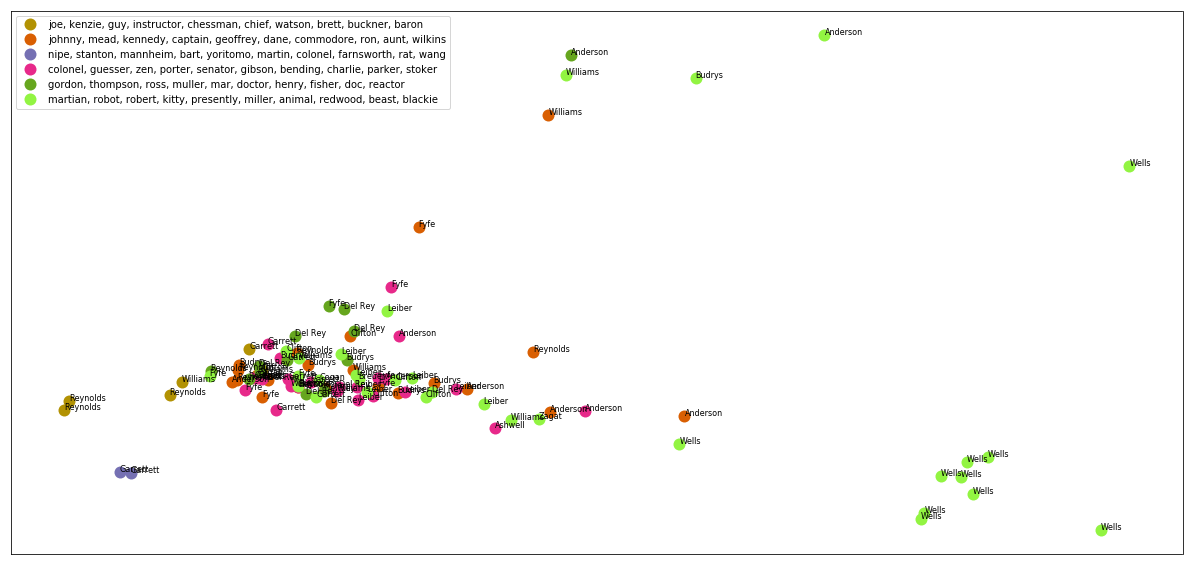

In [199]:
fig, ax = plt.subplots(figsize=(21, 10))

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='False',      # ticks along the bottom edge are off
        top='False',         # ticks along the top edge are off
        labelbottom='False')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='False',      # ticks along the bottom edge are off
        top='False',         # ticks along the top edge are off
        labelleft='False')

ax.legend(numpoints=1)  #show legend with only 1 point

for i in range(len(df)):
    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['author'], size=8)  

plt.show()

## Hierarchical Clustering

/home/glenn/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


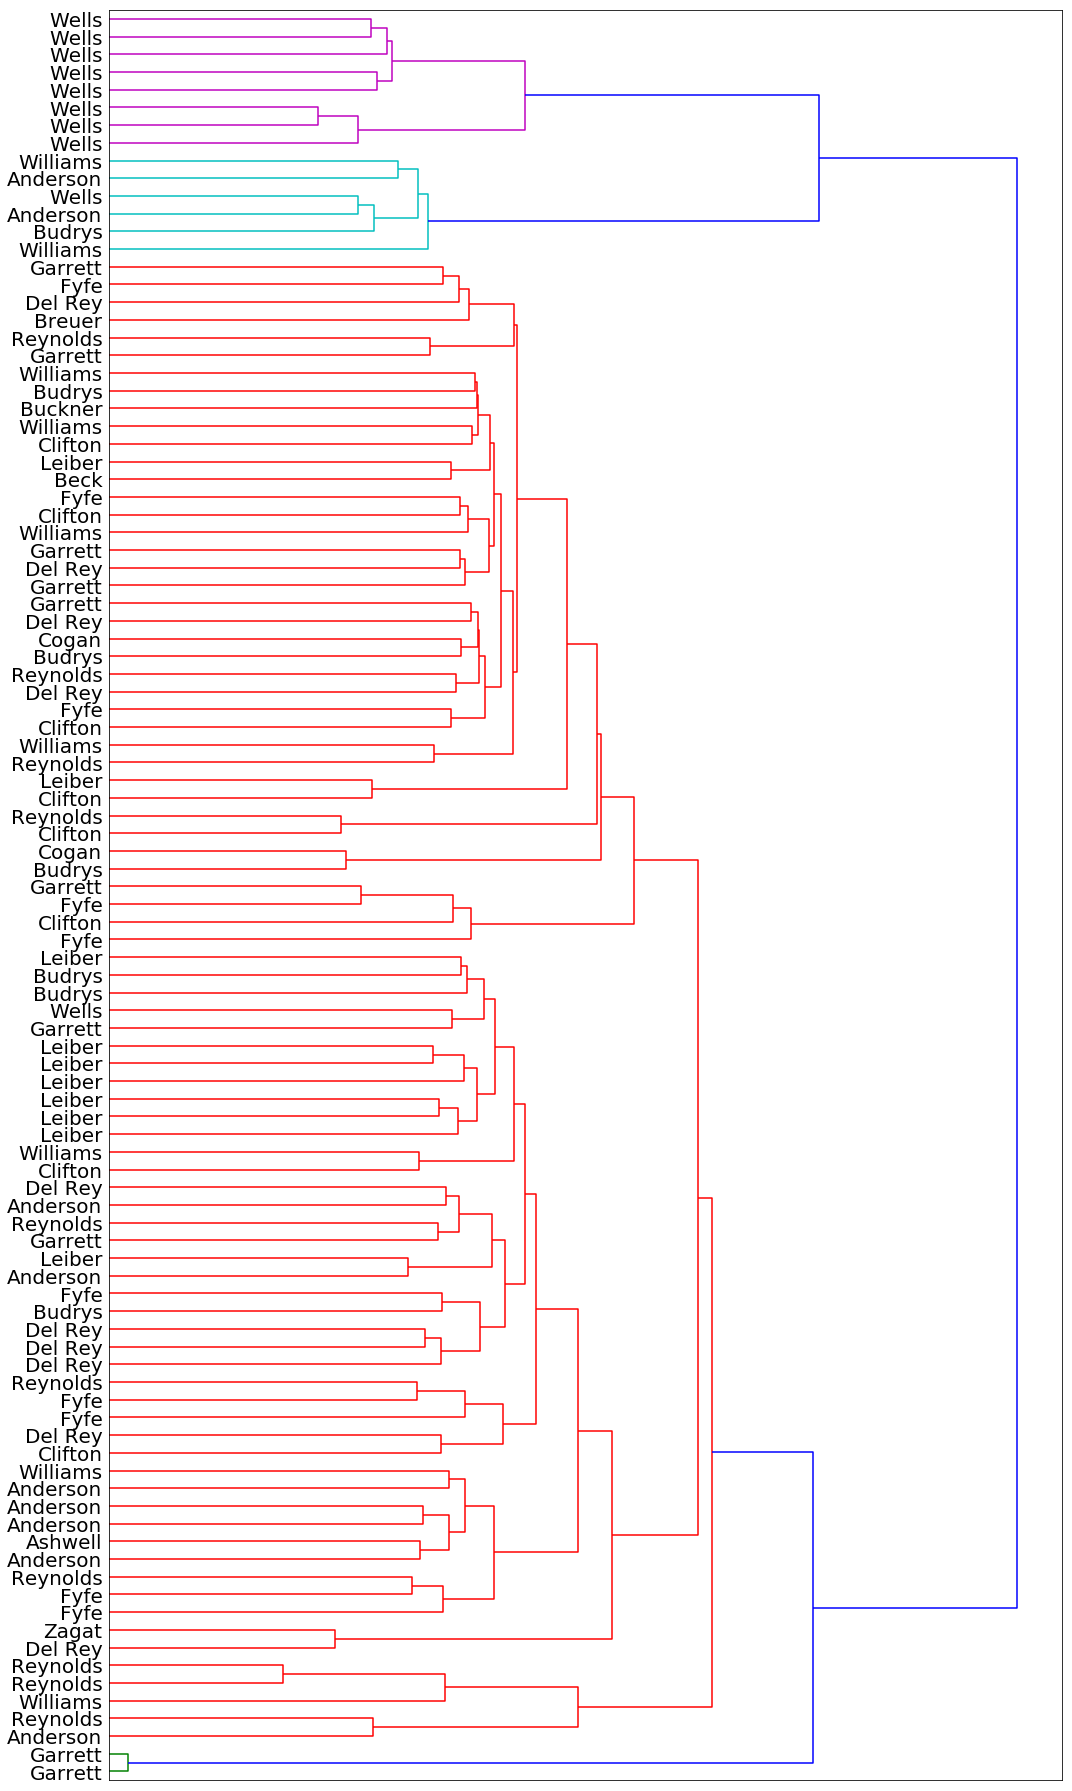

In [212]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist)

fig, ax = plt.subplots(figsize=(15, 25)) # set size

ax = dendrogram(linkage_matrix, orientation="right", labels=y_tfidf);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='False',      # ticks along the bottom edge are off
    top='False',         # ticks along the top edge are off
    labelbottom='False')
plt.tick_params(labelsize=20)
plt.tight_layout() #show plot with tight layout